In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Electricity Supply Dataset (Wind)

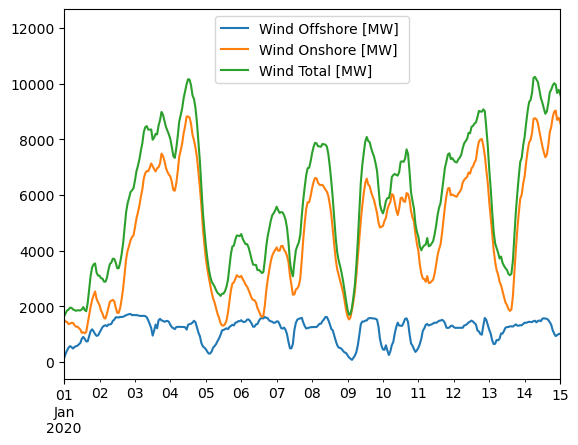

In [2]:
# Import Supply Dataset

sData = pd.read_csv('../Seminar_2024_Data/Realised_Supply_Germany.csv', sep=';', 
                   decimal=',', thousands='.', usecols=[0,1,4,5], dtype={'Date from': object, 'Date to': object})

# casting Year column to datetime object
sData['Date from'] = pd.to_datetime(sData['Date from'], format="%d.%m.%y %H:%M", dayfirst=True) 

# Create new date range as index with frequency (using the one from sData caused trouble)
date_rng = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:45', freq='15min')

# Setting index 
sData = sData.set_index(date_rng)

# Drop Date columns
sData = sData.drop(columns=['Date to', 'Date from'])

# Add Onshore and OffShore Wind together

sData["Wind Total [MW]"] = sData["Wind Offshore [MW] "] + sData["Wind Onshore [MW]"]

# Aggregate Rows into 1 hour steps
sData = sData.resample('h').mean()

# set the recording frequency of the data
sData = sData.asfreq('h')

# Add shifted values (24 hours back) for use as exogenous variable
#sData["pv_lagged"] = sData["Photovoltaic [MW]"].shift(24)

# Drop rows with NaN values (first 24 hours have NaN in "pv_lagged")
#sData.dropna(inplace=True)


# Plot
sData.plot()
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2020-01-15')
plt.xlim(start_date, end_date)

# Drop unused cols
sData = sData.drop(columns=["Wind Offshore [MW] ", "Wind Onshore [MW]"])

# Split Dataset
# The last month of 21 is for validating (744 hours)
train_data, test_data = sData[:"2021-11-30 23:00:00"].copy(), sData["2021-12-01 00:00:00":].copy()


# standardize data
scaler_supply = StandardScaler()
train_data["Wind Total [MW]"] = scaler_supply.fit_transform(train_data["Wind Total [MW]"].values.reshape(-1,1))
test_data["Wind Total [MW]"] = scaler_supply.transform(test_data["Wind Total [MW]"].values.reshape(-1,1))


# Weather Dataset

(18262.0, 18276.0)

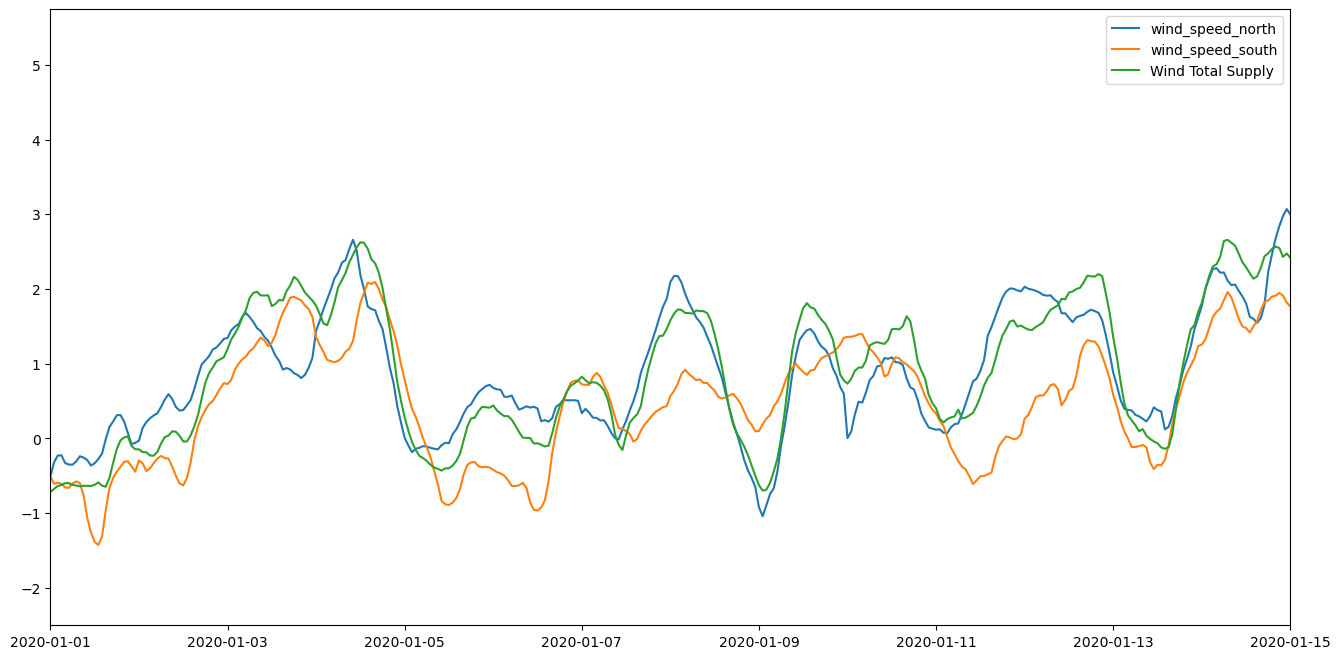

In [3]:
# Import Wheater Dataset
wData = pd.read_csv('../Seminar_2024_Data/Weather_Data_Germany.csv', sep=',', 
                   decimal='.', usecols=['time', 'u100', 'v100', 'latitude'])

#wData.info()

wData22 = pd.read_csv('../Seminar_2024_Data/Weather_Data_Germany_2022.csv', sep=',', 
                   decimal='.', usecols=['time','u100', 'v100', 'latitude'])

# Merge the 2 datasets
wData = pd.concat([wData, wData22]) 
# calculate wind speed

wData["wind_speed"] = np.sqrt(pow(wData['u100'], 2) + pow(wData['v100'], 2))

wData = wData.drop(columns =["u100","v100"])

# casting Year column to datetime object
wData['time'] = pd.to_datetime(wData['time']) 

# Split Weather stations at latitude 53
wData_north = pd.DataFrame(wData[wData["latitude"] >= 53])
wData_south = pd.DataFrame(wData[wData["latitude"] < 53])

# aggregating rows by time, taking mean of the values
wData_north = wData_north.groupby('time', as_index=False, sort=False).mean()
wData_south = wData_south.groupby('time', as_index=False, sort=False).mean()

wData = wData_north
wData = wData.drop(columns=["latitude"])
wData = wData.rename(columns={"wind_speed": "wind_speed_north"})
wData["wind_speed_south"] = wData_south["wind_speed"]

# alternative use every 80th row (use only one station)
#wData = wData.iloc[40::80]
# aggregating rows by time, taking mean of the values
#wData = wData.groupby('time', as_index=False, sort=False).mean() # Here better split: South, North

# Setting index
# Create new date range as index with frequency (using the one from sData caused trouble)
#date_index = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:00', freq='1h')
#wData = wData.set_index(date_index)

# Setting Year as index 
wData = wData.set_index('time')

# set the recording frequency of the Data
wData = wData.asfreq('h')

# Split Dataset
train_data_w, test_data_w = wData[:"2021-11-30 23:00:00"].copy(), wData["2021-12-01 00:00:00":].copy()

# standardize data
scaler_weather = StandardScaler()
train_data_w["wind_speed_north"] = scaler_weather.fit_transform(train_data_w["wind_speed_north"].values.reshape(-1,1))
test_data_w["wind_speed_north"] = scaler_weather.transform(test_data_w["wind_speed_north"].values.reshape(-1,1))
train_data_w["wind_speed_south"] = scaler_weather.fit_transform(train_data_w["wind_speed_south"].values.reshape(-1,1))
test_data_w["wind_speed_south"] = scaler_weather.transform(test_data_w["wind_speed_south"].values.reshape(-1,1))


plt.figure(figsize=(16,8))
plt.plot(train_data_w["wind_speed_north"], label = "wind_speed_north")
plt.plot(train_data_w["wind_speed_south"], label = "wind_speed_south")
plt.plot(train_data["Wind Total [MW]"], label = "Wind Total Supply")
plt.legend()
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2020-01-15')
plt.xlim(start_date, end_date)
#plt.xlim("2020-01-01", "2020-01-08")
# in the plot we see mean wind speed across all stations 
# resembles the wind total supply quite ok
# so we use it as exogenous variable

# Applying the model

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#FORECAST_RANGE = 100 # 744-24
FORECAST_RANGE = 8760 + 744 - 24

In [5]:

# Model definition
model_order = (0,0,0)

exog = train_data_w[["wind_speed_north", "wind_speed_south"]]

# First prediction after end of test_set
model = SARIMAX(train_data, order=model_order, exog=exog)
#model = SARIMAX(train_data, order=model_order)

model_fit = model.fit(disp=False)

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:        Wind Total [MW]   No. Observations:                25560
Model:                        SARIMAX   Log Likelihood                -210.658
Date:                Sat, 15 Jun 2024   AIC                            427.315
Time:                        21:45:43   BIC                            451.762
Sample:                    01-01-2019   HQIC                           435.219
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
wind_speed_north     0.6321      0.002    318.976      0.000       0.628       0.636
wind_speed_south     0.4158      0.002    225.941      0.000       0.412       0.419
sigma2               0.0595 

In [6]:

predictions = []
# Forecast step by step
for i in range(FORECAST_RANGE):
    # Forecast one step then add observed value to model
    yhat = model_fit.forecast(steps=24, exog=test_data_w[i:i+24]).iloc[23]
    predictions.append(yhat)
    model_fit = model_fit.append(test_data[i:i+1], refit=False, exog=test_data_w[i:i+1])



# New df with moved index
predictions = pd.DataFrame(predictions)

# Apply Inverse transform
predictions = scaler_supply.inverse_transform(predictions.values.reshape(1,-1)).flatten()

predicted_energy_supply = pd.DataFrame(predictions, index=test_data.index[23:FORECAST_RANGE+23])

# Save results
predicted_energy_supply.to_pickle("wind_24h.pkl")


Evaluation

In [5]:
# Get results from disk
predicted_energy_supply = pd.read_pickle("wind_24h.pkl")

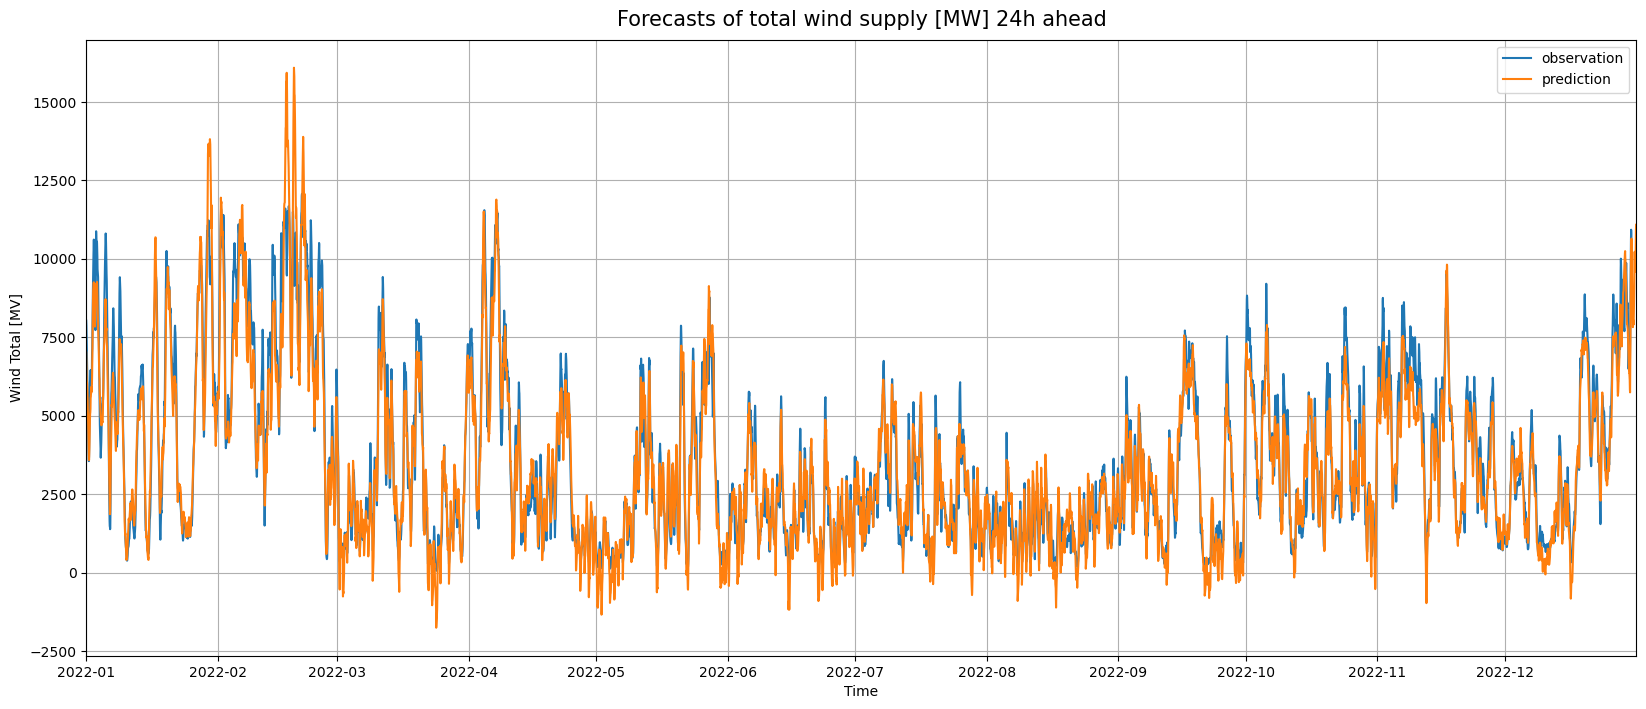

In [6]:
# Construct the set of test target values
y_set = sData["2021-12-01 00:00:00":]

# Overall Plot

plt.figure(figsize=(20,8))
plt.title("Forecasts of total wind supply [MW] 24h ahead", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")

#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wind Total [MV]')
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp("2022-12-31 23:45:00")
plt.xlim(start_date, end_date)
plt.legend()

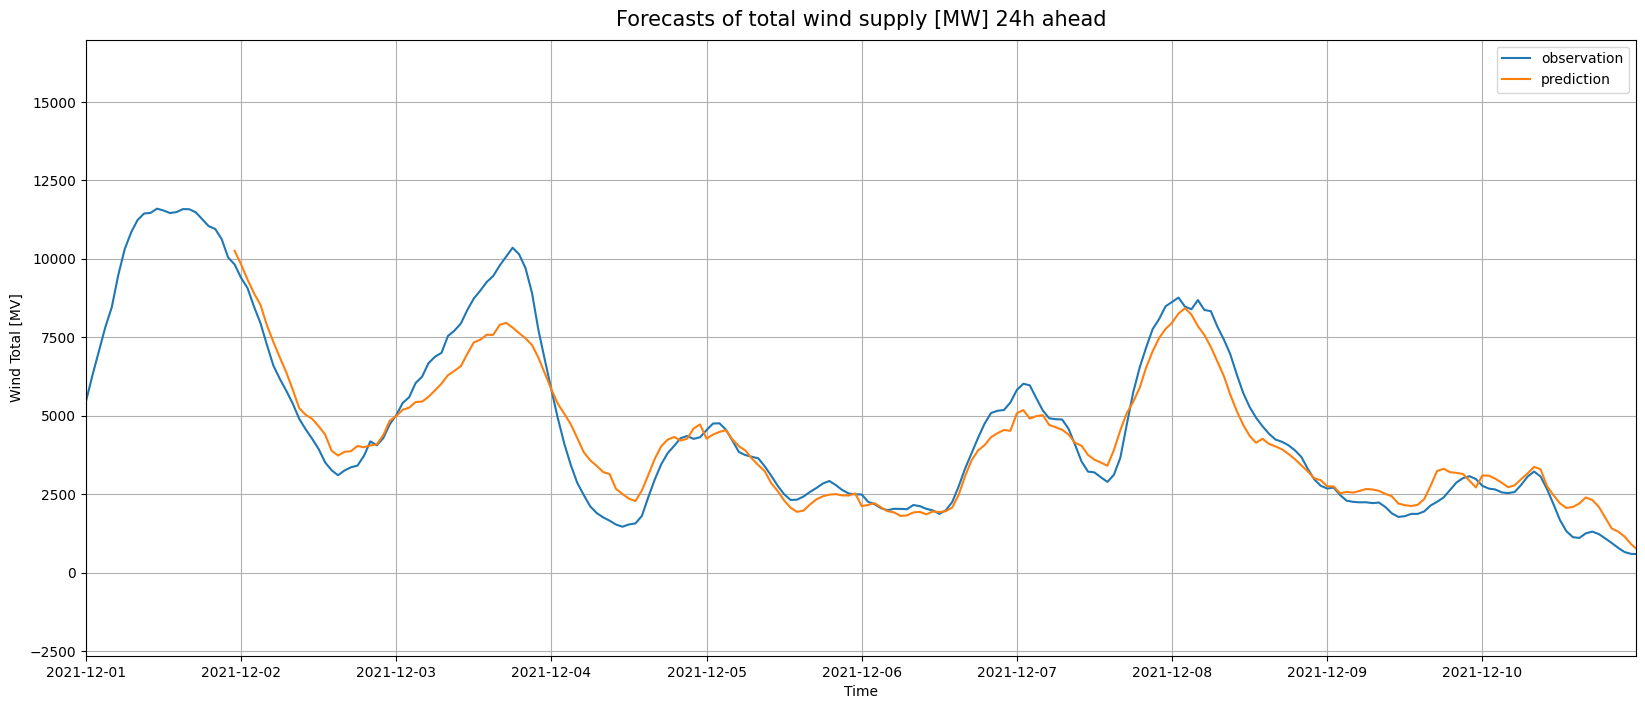

In [9]:
# Detail Plot

plt.figure(figsize=(20,8))
plt.title("Forecasts of total wind supply [MW] 24h ahead", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")

#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wind Total [MV]')
start_date = pd.Timestamp('2021-12-01')
end_date = pd.Timestamp("2021-12-10 23:45:00")
plt.xlim(start_date, end_date)
plt.legend()

In [10]:
# report performance
mse = mean_squared_error(y_set["Wind Total [MW]"][23:FORECAST_RANGE], predicted_energy_supply[:-23])
print('MSE: '+str(mse))
mae = mean_absolute_error(y_set["Wind Total [MW]"][23:FORECAST_RANGE], predicted_energy_supply[:-23])
print('MAE: '+str(mae))
rmse = math.sqrt(mse)
print('RMSE: '+str(rmse))

# Get AIC and BIC values
aic = model_fit.aic
bic = model_fit.bic

print(f"AIC: {aic}, BIC: {bic}")

MSE: 523473.7531044612
MAE: 531.9354674566697
RMSE: 723.5148603204092
AIC: 3960.092682371847, BIC: 3985.4854190069977


100f

- 2,1,2:
RMSE: 4489.507741433077
AIC: -69353.07676521823, BIC: -69296.00821755448
- 2,0,2:
RMSE: 3146.412599898989
AIC: -69709.09662986809, BIC: -69652.0278094009
- 0,0,0:
RMSE: 1161.2094587478923
AIC: 570.8289413649851, BIC: 595.287007279494

year:
- 0,0,0:
RMSE: 723.5148603204092
AIC: 3960.092682371847, BIC: 3985.4854190069977



Plotting the results

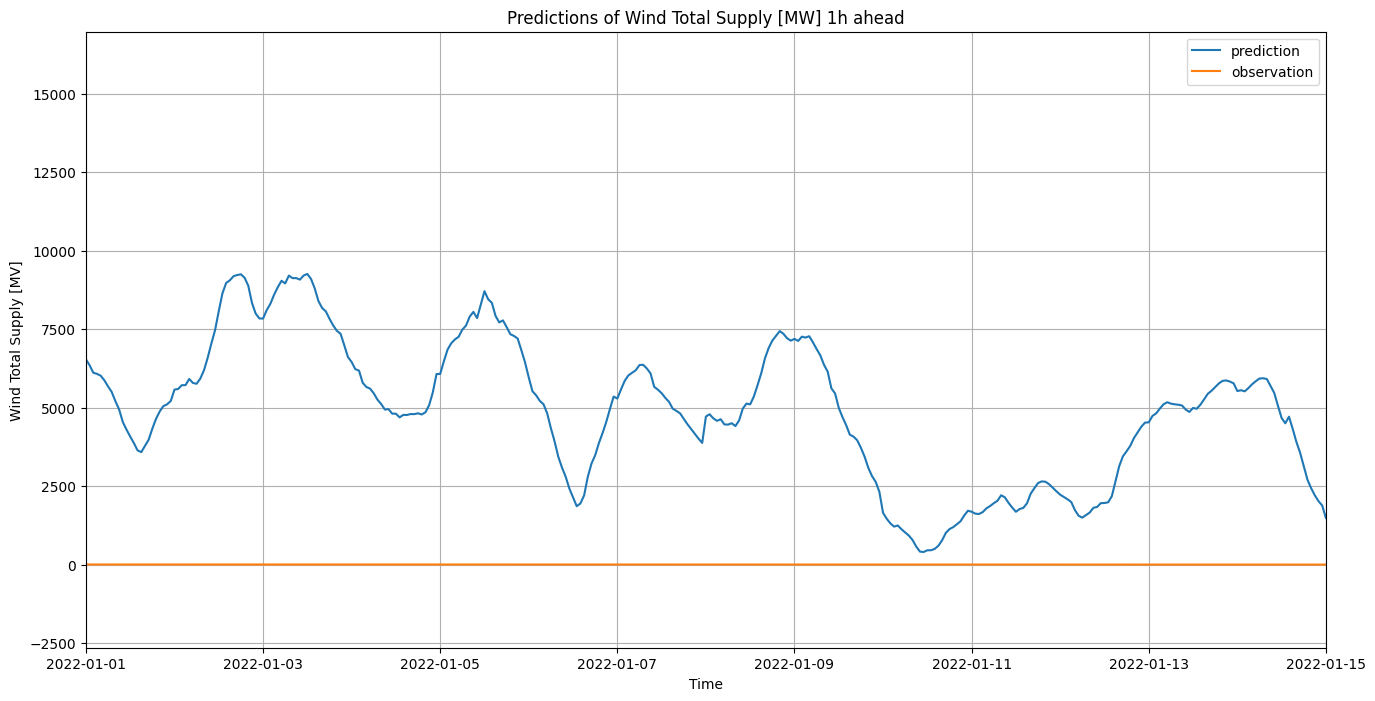

In [11]:
plt.figure(figsize=(16,8))
plt.title('Predictions of Wind Total Supply [MW] 1h ahead')
plt.plot(predicted_energy_supply, label="prediction")
plt.plot(test_data["Wind Total [MW]"], label="observation")
plt.xlabel('Time')
plt.ylabel('Wind Total Supply [MV]')
plt.legend()
plt.grid()
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2022-01-15')
plt.xlim(start_date, end_date)
#plt.savefig('photovoltaik_arima_1h.pdf')
plt.show()


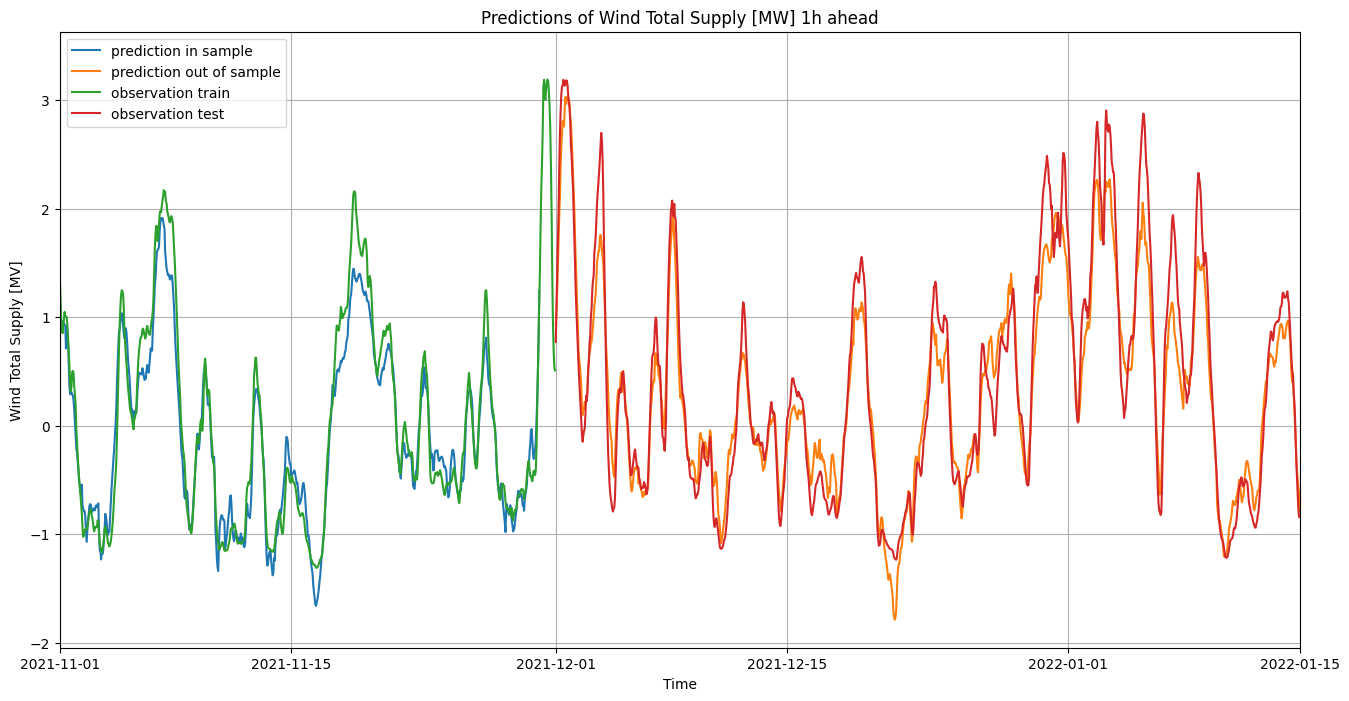

In [12]:
# Plot in Training set prediction
predicted_energy_supply_train = model_fit.predict(
                                            dynamic=False,
                                            start="2021-11-01 00:00:00", end="2021-11-30 00:00:00",
                                            exog=train_data_w[:"2021-11-30 00:00:00"])
                                             
predicted_energy_supply_test = model_fit.predict(
                                            dynamic="2021-11-24 00:00:00",
                                            start="2021-12-01 00:00:00", end="2022-01-15 00:00:00",
                                            exog=test_data_w[:"2022-01-15 00:00:00"])

plt.figure(figsize=(16,8))
plt.title('Predictions of Wind Total Supply [MW] 1h ahead')
plt.plot(predicted_energy_supply_train, label="prediction in sample")
plt.plot(predicted_energy_supply_test, label="prediction out of sample")
plt.plot(train_data["Wind Total [MW]"], label="observation train")
plt.plot(test_data["Wind Total [MW]"], label="observation test")
plt.xlabel('Time')
plt.ylabel('Wind Total Supply [MV]')
plt.legend()
plt.grid()
start_date = pd.Timestamp('2021-11-01')
end_date = pd.Timestamp('2022-01-15')
plt.xlim(start_date, end_date)
#plt.savefig('wind_arima_010_wind_as_X_1h.pdf')
plt.show()

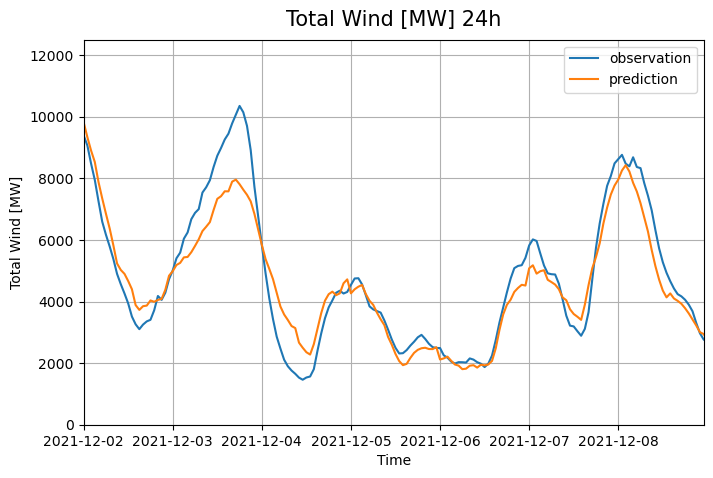

In [17]:
# Detail Plot 2 to show validation set forecast

plt.figure(figsize=(8,5))
plt.title("Total Wind [MW] 24h", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")
#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Total Wind [MW]')
start_date = pd.Timestamp('2021-12-02 00:00:00')
end_date = pd.Timestamp("2021-12-08 23:00:00")
plt.xlim(start_date, end_date)
plt.ylim(0, 12500)
plt.legend()